In [177]:
import time
import numpy as np
import matplotlib.pyplot as plt

In [178]:
#Constantes

L = 2 #[m]
dL= 0.1
q = 400 # [W/m^3]
Ta = 258 # [Kelvin]
i = 1000 # Nombre de pas du maillage spatial
ti = 0
tf = 10**7
dt = 400
p = (tf-ti)/400
k = 0.5
h = 20
Xi = 0.5
Cv = 1000
rho = 2000
# [m]

In [179]:
#Conditions frontieres
# à x=0 : c1*T'(0)+c2*T(0) + c3 = 0 ; à x=L d1*T'(L) + d2*T(L) + d3 = 0
c1 = -k
c2 = h
c3 = -h*Ta
d1 = -k
d2 = -h
d3 = h*Ta


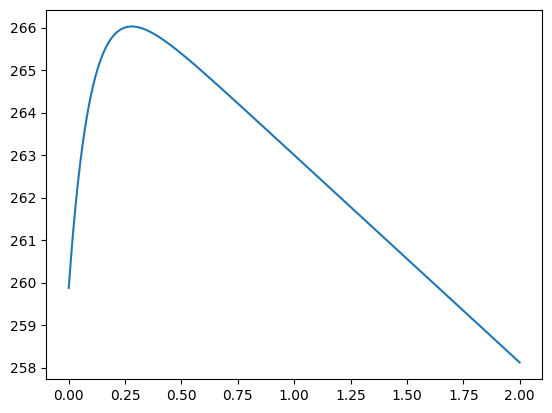

In [180]:
#Initialisations
S=np.zeros(i+1,dtype=np.double)
A=np.zeros((i+1,i+1),dtype=np.double)
b=np.zeros(i+1,dtype=np.double)
u=np.zeros(i+1,dtype=np.double)

dx=L/i; #Pas de discrétisation
x=np.linspace(0,L,i+1)
S=(q*np.exp(-x/dL))/k

u0=np.full(i+1,Ta,dtype=np.double)
A=np.diag(-2*np.ones(i+1),0)+np.diag(np.ones(i),-1)+np.diag(np.ones(i),1)
A[0,0]=(2*c2*dx-3*c1)*Xi;A[0,1]=(4*c1)*Xi;A[0,2]=-c1*Xi
A[i,i]=(3*d1+2*d2*dx)*Xi;A[i,i-1]=-4*d1*Xi;A[i,i-2]=d1*Xi
b=-S*dx**2; b[0]=-2*c3*dx-(2*c2*dx-3*c1)*(1-Xi)*u0[0]-4*c1*(1-Xi)*u0[1]+c1*(1-Xi)*u0[2] 
b[i]=-2*d3*dx-d1*(1-Xi)*u0[i-2]+4*d1*(1-Xi)*u0[i-1]-(2*d2*dx+3*d1)*(1-Xi)*u0[i]
u=np.linalg.solve(A, b); # Option préférée

    
Tmax=u.max()
plt.plot(x,u)

In [181]:
#Time dependancy

M=np.diag(np.ones(i+1))

M[0,0]=0
M[i,i]=0
alpha = (Cv*rho)/k
A_prime = M-(dt/(alpha*dx**2))*Xi*A
b_prime = (M+(dt/(alpha*dx**2))*(1-Xi)*A)@u0-(dt/(alpha*dx**2))*(Xi*b+(1-Xi)*b)

t=ti
T_max=[]
ci=1

while t<tf:
    
    ci+=1
    uf=np.linalg.solve(A_prime,b_prime)
    T_max.append(uf.max())
    b_prime = (M+(dt/(alpha*dx**2))*(1-Xi)*A)@uf-(dt/(alpha*dx**2))*(Xi*b+(1-Xi)*b)
    t=t+dt





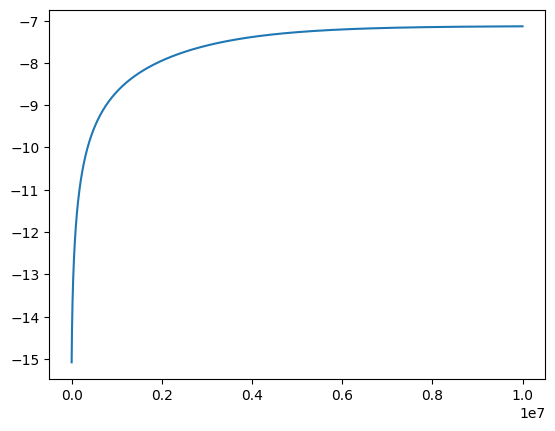

In [182]:
x=np.linspace(ti,tf,len(T_max))
T_max=np.array(T_max)
T_max=T_max - 273.15
plt.plot(x,T_max)


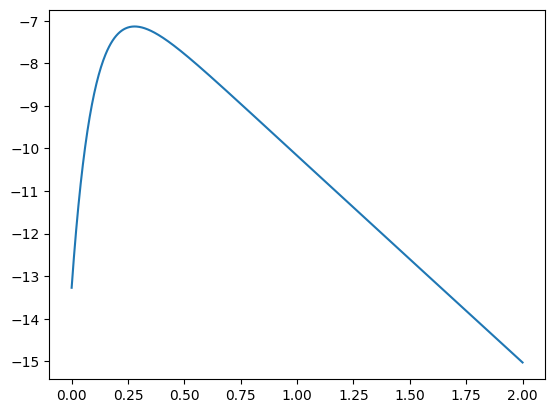

In [183]:
x=np.linspace(0,L,len(uf))
uf=np.array(uf)
uf=uf-273.15
plt.plot(x,uf)

In [184]:
print(uf.max())

-7.132670563449494
